In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import itertools

import astropy
from astropy.table import Table

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier

from astroML.utils import split_samples, completeness_contamination

import warnings
warnings.filterwarnings("ignore")
import h5py

In [2]:
file = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')

print('keys: ', list(file.keys()))

data=[]
key_data=[]
maxdata=int(1e5) #smaller sample of data
for i in list(file.keys()):
    if i!='det' and i!='snr':
        data.append((file[i][:maxdata]))
        key_data.append(i)
data=np.array(data)
print('data: ', data.shape, '\n', data)
print('data keys: ', key_data)

labels=file['det'][:maxdata]
print('labels if signal or not: ', labels)

snr=file['snr'][:maxdata]

keys:  ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
data:  (13, 100000) 
 [[-0.3072008  -0.7347119  -0.05783062 ...  0.65272199 -0.13497691
  -0.05363359]
 [ 0.27616489 -0.49849269 -0.70379617 ... -0.02226377  0.01640865
  -0.63317114]
 [-0.43075952 -0.29816229 -0.35451167 ...  0.13214517 -0.20757182
   0.00473647]
 ...
 [ 0.62478004  0.98665033  0.28619935 ...  0.72273304  0.45948906
   0.8265149 ]
 [-3.11678443  1.36029119  0.07997326 ...  0.44419445 -0.41532972
   1.23350759]
 [ 2.13965943  2.43870712  1.86946125 ...  0.73558851  0.39483305
   0.41619384]]
data keys:  ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']
labels if signal or not:  [0 0 0 ... 1 1 1]


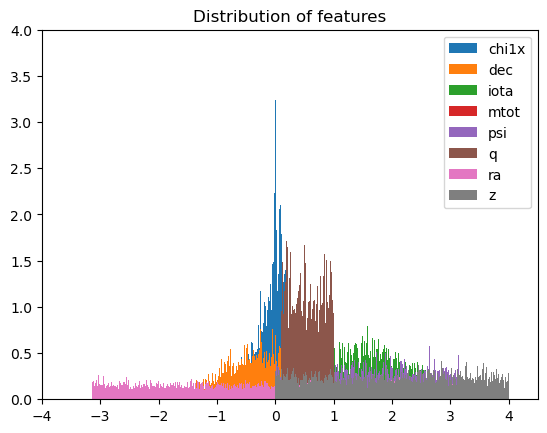

In [3]:
#histogram of the distribution of the features
N_bins=20

bins_set=np.append(np.sort(data[0])[::N_bins], np.max(data[0]))
plt.hist(data[0], bins=bins_set, density=True, label=str(key_data[0]))

for i in range(6,13):
    bins_set=np.append(np.sort(data[i])[::N_bins], np.max(data[i]))
    plt.hist(data[i], bins=bins_set, density=True, label=str(key_data[i]))

plt.title('Distribution of features')
plt.legend()
plt.xlim(-4,4.5)
plt.ylim(0,4)
plt.show()

In [4]:
#dividng in train and test for CV on tree depth
x_train_CV, x_test_CV, y_train_CV, y_test_CV = train_test_split(data.T, labels.ravel(), test_size=0.2, random_state=42)

Depth= 2 0.217296788150973 0.2177967168182557
Depth= 3 0.20970926914606347 0.21080874795965018
Depth= 4 0.20122659617654637 0.20391393111135594
Depth= 5 0.19304665974299326 0.197405003500665
Depth= 6 0.18243037850951338 0.18952444200401702
Depth= 7 0.1738524926408505 0.1845040874768714
Depth= 8 0.16400068517660155 0.17841636914831707
Depth= 9 0.15649994335793588 0.1776223570282121
Depth= 10 0.14748383881989235 0.1793852264153219
Depth= 11 0.1368475170835914 0.1828968938870492
Depth= 12 0.12566893674852 0.18869295170007389
Depth= 13 0.11317874073627471 0.1953935519230532
Depth= 14 0.09981954058591197 0.20089245961114083
Depth= 15 0.08682384024448998 0.20803756922084127
Depth= 16 0.07490963808291635 0.21164026962485682
Depth= 17 0.0632304108364779 0.2134952907284766
Depth= 18 0.054100063732807506 0.21892260584012316
Depth= 19 0.045614403059312525 0.21860900090993926
Best 9 0.1776223570282121


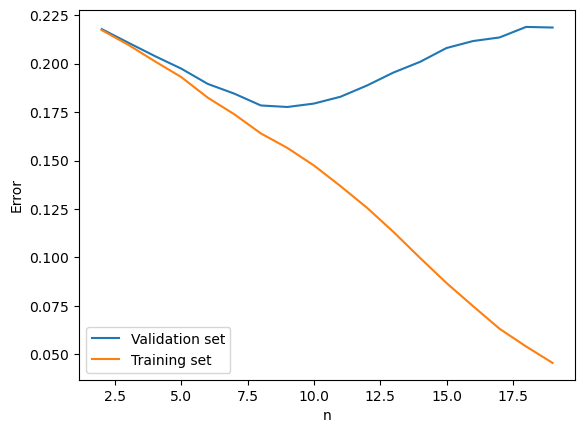

In [5]:
#range for which I test the depth 
n_depth = np.arange(2,20)

err_train_tot, err_test_tot= [], []
for n in n_depth:
    dtree = DecisionTreeClassifier(max_depth=n, criterion='entropy')
    dtree.fit(x_train_CV,y_train_CV)

    error_train_tot = np.sqrt( np.sum((y_train_CV-dtree.predict_proba(x_train_CV)[:,1] )**2) / len(x_train_CV) )
    error_validation_tot = np.sqrt( np.sum((y_test_CV-dtree.predict_proba(x_test_CV)[:,1] )**2) / len(x_test_CV) )

    #value of error in train and test
    print("Depth=",n, error_train_tot, error_validation_tot)
    err_train_tot.append(error_train_tot)
    err_test_tot.append(error_validation_tot)

plt.plot(n_depth,err_test_tot, label='Validation set')
plt.plot(n_depth,err_train_tot, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()

#find the best number of neighbors from minimum of test
best_n_depth_tot=n_depth[np.argmin(err_test_tot)]
print("Best", best_n_depth_tot, min(err_test_tot))

plt.show()

In [6]:
#goes in overfit of the data for depth bigger than 9

In [7]:
#dividng in train and test
x_train, x_test, y_train, y_test = train_test_split(data.T, labels.ravel(), test_size=0.3, random_state=42)

In [8]:
#Decision tree with all features

dtree_tot = DecisionTreeClassifier(max_depth=best_n_depth_tot, criterion='entropy')
dtree_tot.fit(x_train,y_train)

#compute the importance for each feature = how much feature contributed to reduce impurity in all splits
importances = dtree_tot.feature_importances_
y_probs_tot = dtree_tot.predict_proba(x_test)[:,1]

fpr_tot, tpr_tot, thresh_tot=[], [], [] 
completeness_train_tot, contamination_train_tot=[], [] 

y_pred_tot = (y_probs_tot >= 0.5).astype(int)
C = sklearn.metrics.confusion_matrix(y_test, y_pred_tot)
tn, fp, fn, tp = C.ravel() #false positive/true positive rates
#completeness an contamination
completeness_train_tot=(tp/(tp+fn))
contamination_train_tot=(fp/(tp+fp))
    
fpr_tot, tpr_tot, thresh_tot= roc_curve(y_test, y_probs_tot)

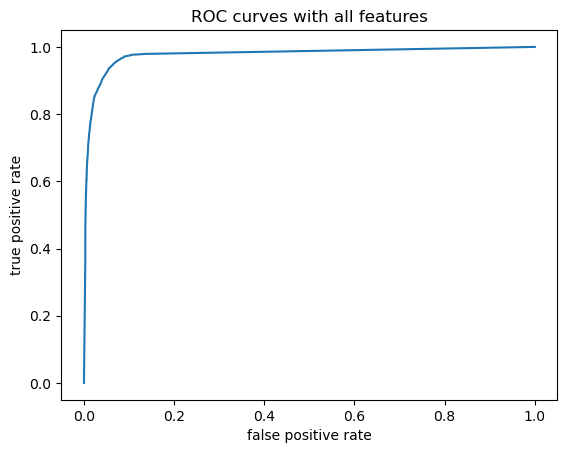

In [9]:
#plot of ROC curve with all features of the data
fig, axes = plt.subplots(1, 1)

axes.plot(fpr_tot, tpr_tot)

axes.title.set_text('ROC curves with all features')
axes.set_xlabel('false positive rate')
axes.set_ylabel('true positive rate')
fig.show()

In [10]:
#most important features
print('Values of importances for each feature in the tree:\n', importances, '\n')
imp_features_n=importances.argsort()[::-1]
print('Order of importance of the features: ', imp_features_n, '\n', np.array(key_data)[imp_features_n])

Values of importances for each feature in the tree:
 [0.00152234 0.00142609 0.0180027  0.00085606 0.00123798 0.00210059
 0.00119791 0.06372251 0.07270723 0.00207242 0.02539404 0.0014851
 0.80827502] 

Order of importance of the features:  [12  8  7 10  2  5  9  0 11  1  4  6  3] 
 ['z' 'mtot' 'iota' 'q' 'chi1z' 'chi2z' 'psi' 'chi1x' 'ra' 'chi1y' 'chi2y'
 'dec' 'chi2x']


In [11]:
#function for computing decision tree
def compute_tree(x,y,depth,test):
    predict = []
    
    for i in range(len(key_data)): #each time a feature is added
        dtree = DecisionTreeClassifier(max_depth=depth[i], criterion='entropy')
        dtree.fit(x[:, 0:i+1],y) 

        y_probs = dtree.predict_proba(test[:, 0:i+1])[:,1]

        predict.append(y_probs)

    return np.array(predict)

In [12]:
#CV for depth for each feature added

#range for which I test the depth 
n_depth_features = np.arange(2,15)

err_train_features=[]
err_test_features= []
best_n_depth_features=[]

for f in range(len(key_data)):
    err_train_1f, err_test_1f=[],[]
    
    for n in n_depth_features:
        dtree = DecisionTreeClassifier(max_depth=n, criterion='entropy')
        dtree.fit(x_train_CV[:,0:f+1],y_train_CV)

        error_train_1f = np.sqrt( np.sum((y_train_CV-dtree.predict_proba(x_train_CV[:,0:f+1])[:,1] )**2) / len(x_train_CV[:,0:f+1]) )
        error_validation_1f = np.sqrt( np.sum((y_test_CV-dtree.predict_proba(x_test_CV[:,0:f+1])[:,1] )**2) / len(x_test_CV[:,0:f+1]) )

        err_train_1f.append(error_train_1f)
        err_test_1f.append(error_validation_1f)
    
    best_n_depth_features.append(n_depth_features[np.argmin(err_test_1f)])
    err_train_features.append(err_train_1f)
    err_test_features.append(err_test_1f)

print('Best depth for each feature added: ', best_n_depth_features)

Best depth for each feature added:  [3, 2, 2, 2, 2, 2, 2, 3, 6, 4, 5, 5, 9]


In [13]:
#decision tree for features

all_predict_features = compute_tree(x_train, y_train, best_n_depth_features, x_test)
fpr_features, tpr_features, thresh_features=[], [], []
completeness_train_features, contamination_train_features=[], []

#ROC curve for each feature
for i in range(len(key_data)):
    all_y_pred_features = (all_predict_features[i] >= 0.5).astype(int)
    
    C = sklearn.metrics.confusion_matrix(y_test, all_y_pred_features)
    tn, fp, fn, tp = C.ravel()

    completeness_train_features.append(tp / (tp + fn) if (tp + fn) > 0 else 1)
    contamination_train_features.append(fp / (tp + fp) if (tp + fp) > 0 else 1)
    
    fpr, tpr, thresh = roc_curve(y_test, all_predict_features[i])
    fpr_features.append(fpr)
    tpr_features.append(tpr)
    thresh_features.append(thresh)

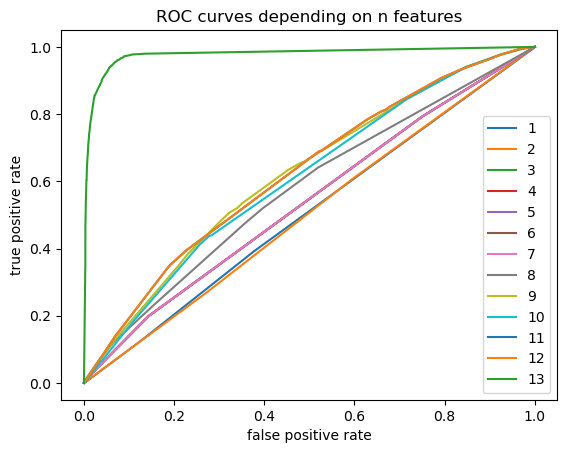

In [14]:
#Plot ROC curve
fig, axes = plt.subplots(1, 1)
for i in range(len(key_data)):
    axes.plot(fpr_features[i], tpr_features[i], label=str(i+1))

axes.legend(loc='lower right')
axes.title.set_text('ROC curves depending on n features')
axes.set_xlabel('false positive rate')
axes.set_ylabel('true positive rate')
fig.show()

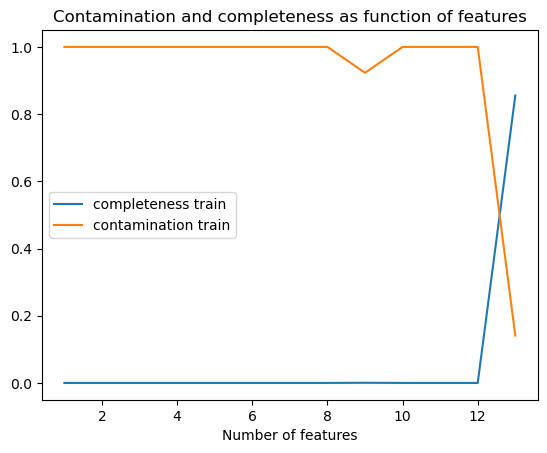

In [15]:
#plot of completeness and contamination evolution with adding features
features= np.arange(1,14)
plt.plot(features, completeness_train_features, label='completeness train')
plt.plot(features, contamination_train_features, label='contamination train')
plt.legend()
plt.xlabel('Number of features')
plt.title('Contamination and completeness as function of features')
plt.show()

In [16]:
#Flip of the features to start with last one
x_train_flip= np.flip(np.array(x_train), axis=1)
x_test_flip= np.flip(np.array(x_test), axis=1)

x_train_CV_flip= np.flip(np.array(x_train_CV), axis=1)
x_test_CV_flip= np.flip(np.array(x_test_CV), axis=1)

In [17]:
#CV for depth for each feature added

#range for which I test the depth 
n_depth_features_flip = np.arange(2,15)

err_train_features_flip=[]
err_test_features_flip= []
best_n_depth_features_flip=[]

for f in range(len(key_data)):
    err_train_1f_flip, err_test_1f_flip=[],[]
    
    for n in n_depth_features_flip:
        dtree = DecisionTreeClassifier(max_depth=n, criterion='entropy')
        dtree.fit(x_train_CV_flip[:,0:f+1],y_train_CV)

        error_train_1f_flip = np.sqrt( np.sum((y_train_CV-dtree.predict_proba(x_train_CV_flip[:,0:f+1])[:,1] )**2) / len(x_train_CV_flip[:,0:f+1]) )
        error_validation_1f_flip = np.sqrt( np.sum((y_test_CV-dtree.predict_proba(x_test_CV_flip[:,0:f+1])[:,1] )**2) / len(x_test_CV_flip[:,0:f+1]) )

        err_train_1f_flip.append(error_train_1f_flip)
        err_test_1f_flip.append(error_validation_1f_flip)
    best_n_depth_features_flip.append(n_depth_features_flip[np.argmin(err_test_1f_flip)])
    err_train_features_flip.append(err_train_1f_flip)
    err_test_features_flip.append(err_test_1f_flip)

print('Best depth for each feature added (flipped vector): ', best_n_depth_features_flip)

Best depth for each feature added (flipped vector):  [4, 5, 6, 6, 7, 9, 9, 9, 9, 9, 9, 9, 9]


In [18]:
#decision tree for features flip
all_predict_features_flip = compute_tree(x_train_flip, y_train, best_n_depth_features_flip, x_test_flip)
fpr_features_flip, tpr_features_flip, thresh_features_flip=[], [], []
completeness_train_features_flip, contamination_train_features_flip=[],[]

#ROC curve for each feature (flipped)
for i in range(len(key_data)):
    all_y_pred_features_flip = (all_predict_features_flip[i] >= 0.5).astype(int)
    
    C = sklearn.metrics.confusion_matrix(y_test, all_y_pred_features_flip)
    tn, fp, fn, tp = C.ravel()

    completeness_train_features_flip.append(tp / (tp + fn) if (tp + fn) > 0 else 1)
    contamination_train_features_flip.append(fp / (tp + fp) if (tp + fp) > 0 else 1)
    
    fpr_flip, tpr_flip, thresh_flip = roc_curve(y_test, all_predict_features_flip[i])
    fpr_features_flip.append(fpr_flip)
    tpr_features_flip.append(tpr_flip)
    thresh_features_flip.append(thresh_flip)

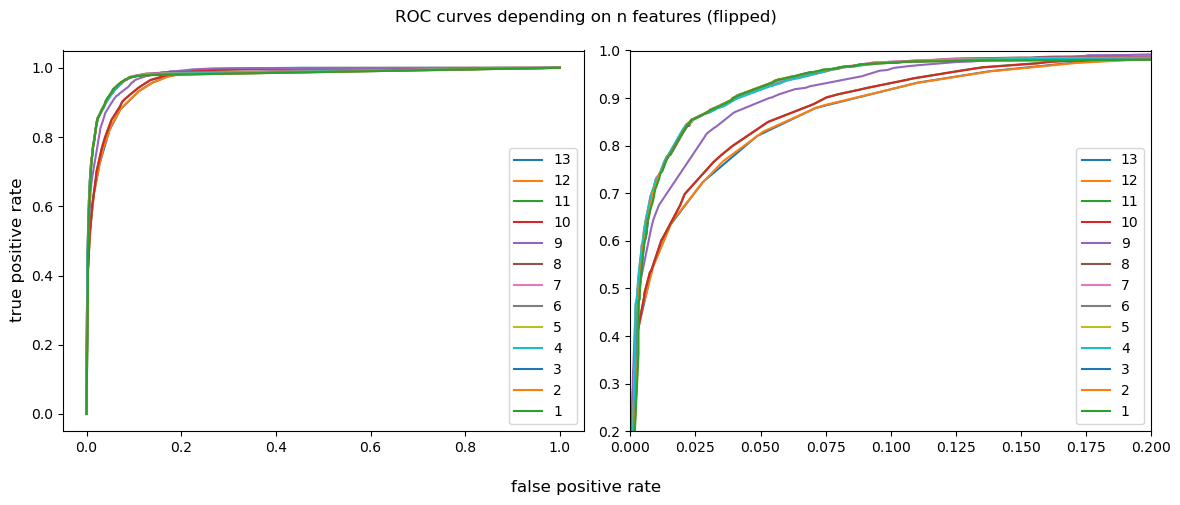

In [19]:
#Plot ROC curve flipped features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(key_data)):
    axes[0].plot(fpr_features_flip[i], tpr_features_flip[i], label=str(13-i))

axes[0].legend(loc='lower right')

#Plot ROC curve flipped features (zoomed)
for i in range(len(key_data)):
    axes[1].plot(fpr_features_flip[i], tpr_features_flip[i], label=str(13-i))

axes[1].legend(loc='lower right')
axes[1].set_xlim(0,0.2)
axes[1].set_ylim(0.2,1)

fig.supxlabel('false positive rate')
fig.supylabel('true positive rate')
fig.suptitle('ROC curves depending on n features (flipped)')

plt.tight_layout()

fig.show()

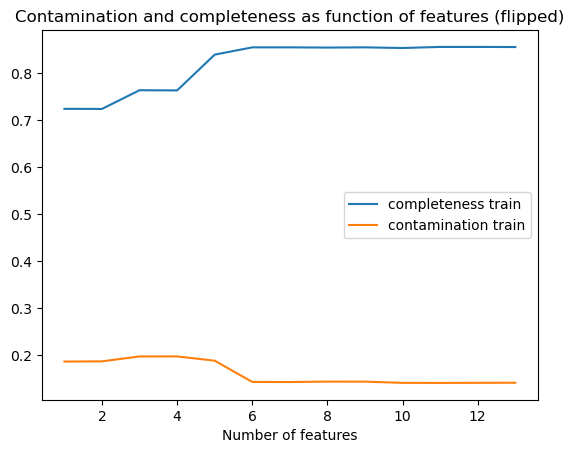

In [20]:
#plot of completeness and contamination evolution with adding features (flipped)
features= np.arange(1,14)
plt.plot(features, completeness_train_features_flip, label='completeness train')
plt.plot(features, contamination_train_features_flip, label='contamination train')
plt.legend()
plt.xlabel('Number of features')
plt.title('Contamination and completeness as function of features (flipped)')
plt.show()

In [21]:
#use only the first 3 important features
x_train_best_features=x_train[:, imp_features_n[0:3]]
x_test_best_features=x_test[:, imp_features_n[0:3]]

x_train_CV_best_features = x_train_CV[:, imp_features_n[0:3]]
x_test_CV_best_features=x_test_CV[:,imp_features_n[0:3]]

In [22]:
#function for computing decision tree with only best features
def compute_tree_best(x,y,depth,test):
    predict = []
    
    for i in range(len(x_train_best_features[0])): #each time a feature is added
        dtree = DecisionTreeClassifier(max_depth=depth[i], criterion='entropy')
        dtree.fit(x[:, 0:i+1],y) 

        y_probs = dtree.predict_proba(test[:, 0:i+1])[:,1]

        predict.append(y_probs)

    return np.array(predict)

In [23]:
#CV for depth for each feature added

#range for which I test the depth 
n_depth_best_features = np.arange(2,15)

err_train_best_features=[]
err_test_best_features= []
best_n_depth_best_features=[]

for f in range(len(x_train_best_features[0])):
    err_train_best_1f, err_test_best_1f=[],[]
    
    for n in n_depth_best_features:
        dtree = DecisionTreeClassifier(max_depth=n, criterion='entropy')
        dtree.fit(x_train_CV_best_features[:,0:f+1],y_train_CV)

        error_train_best_1f = np.sqrt( np.sum((y_train_CV-dtree.predict_proba(x_train_CV_best_features[:,0:f+1])[:,1] )**2) / len(x_train_CV_best_features[:,0:f+1]) )
        error_validation_best_1f = np.sqrt( np.sum((y_test_CV-dtree.predict_proba(x_test_CV_best_features[:,0:f+1])[:,1] )**2) / len(x_test_CV_best_features[:,0:f+1]) )

        err_train_best_1f.append(error_train_best_1f)
        err_test_best_1f.append(error_validation_best_1f)
    
    best_n_depth_best_features.append(n_depth_best_features[np.argmin(err_test_best_1f)])
    err_train_best_features.append(err_train_best_1f)
    err_test_best_features.append(err_test_best_1f)

print('Best depth for each feature added: ', best_n_depth_best_features)

Best depth for each feature added:  [4, 8, 9]


In [24]:
#decision tree for each of the 3 features

predict_best_features = compute_tree_best(x_train_best_features, y_train, best_n_depth_best_features, x_test_best_features)
fpr_best_features, tpr_best_features, thresh_best_features=[], [], []
completeness_train_best_features, contamination_train_best_features=[], []

#ROC curve for each of the 3 feature
for i in range(len(x_train_best_features[0])):
    y_pred_best_features = (predict_best_features[i] >= 0.5).astype(int)
    
    C = sklearn.metrics.confusion_matrix(y_test, y_pred_best_features)
    tn, fp, fn, tp = C.ravel()

    completeness_train_best_features.append(tp / (tp + fn) if (tp + fn) > 0 else 1)
    contamination_train_best_features.append(fp / (tp + fp) if (tp + fp) > 0 else 1)
    
    fpr, tpr, thresh = roc_curve(y_test, predict_best_features[i])
    fpr_best_features.append(fpr)
    tpr_best_features.append(tpr)
    thresh_best_features.append(thresh)

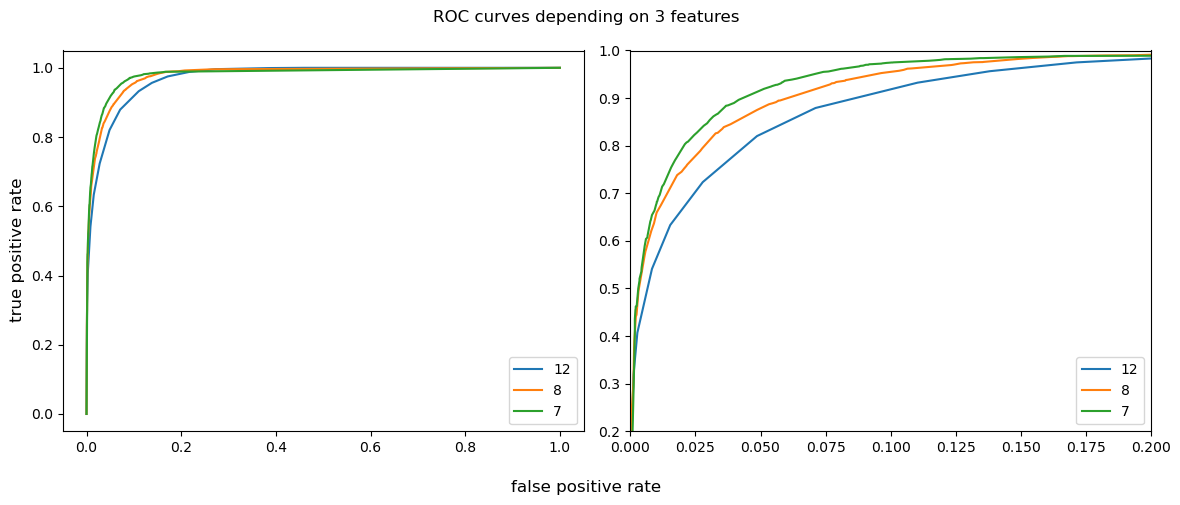

In [25]:
#Plot ROC curve 3 best features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(len(x_train_best_features[0])):
    axes[0].plot(fpr_best_features[i], tpr_best_features[i], label=str(imp_features_n[i]))

axes[0].legend(loc='lower right')

#Plot ROC curve 3 best features (zoomed)
for i in range(len(x_train_best_features[0])):
    axes[1].plot(fpr_best_features[i], tpr_best_features[i], label=str(imp_features_n[i]))

axes[1].legend(loc='lower right')
axes[1].set_xlim(0,0.2)
axes[1].set_ylim(0.2,1)

fig.supxlabel('false positive rate')
fig.supylabel('true positive rate')
fig.suptitle('ROC curves depending on 3 features')

plt.tight_layout()

fig.show()

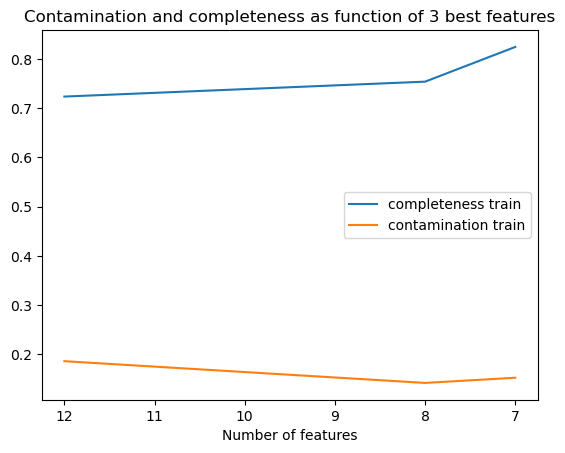

In [26]:
#plot of completeness and contamination evolution with adding 3 best features
best_features=np.array(imp_features_n[0:3])
plt.plot(best_features, completeness_train_best_features, label='completeness train')
plt.plot(best_features, contamination_train_best_features, label='contamination train')
plt.legend(loc='center right')
plt.gca().invert_xaxis()
plt.xlabel('Number of features')
plt.title('Contamination and completeness as function of 3 best features')
plt.show()